## La Arquitectura Transformer

* 2017: La arquitectura Transformer supera a las RNN en la mayoría de las tareas de PLN.
* Paper: [“Attention is all you need” by Vaswani et al](https://arxiv.org/abs/1706.03762) 
* La esencia del artículo está en el título: mecanismo simple llamado **"atención neuronal"** se usan para construir **poderosos modelos de secuencia** que no presentaban capas recurrentes o capas de convolución.
* Ha provocado una verdadera revolución en el PLN. Ahora es una de las ideas más influyentes del deep learning. 

Crearemos lo que se llama **Transformer Encoder**, uno de los componentes básicos de la arquitectura de Transformer, y lo aplicaremos a la tarea de clasificación de reseñas de películas de IMDB.

### Entendiendo self-attention

* BASE: No toda la información de entrada que ve un modelo es igualmente importante para la tarea en cuestión, por lo que **los modelos deben "prestar más atención" a algunas características y "prestar menos atención" a otras características**.

Este concepto lo hemos visto en:

* **Max pooling  en Redes convolucionales**. Forma de atención de "todo o nada": mantener la característica más importante y descartar el resto.
* La **normalización TF-IDF** asigna puntajes de importancia a los tokens en función de la cantidad de información que es probable que lleven los diferentes tokens. Los tokens importantes se potencian mientras que las tokens irrelevantes se desvanecen.

La atención se podría implementar de muchas formas diferentes, pero todas se basan en **calcular puntuaciones de importancia para un conjunto de características**, con **puntuaciones más altas para las características más relevantes** y **puntuaciones más bajas para las menos relevantes**.

**El concepto general de "atención" en el aprendizaje profundo: a las características de entrada se les asignan "puntajes de atención", que se pueden usar para informar la siguiente representación de la entrada.**

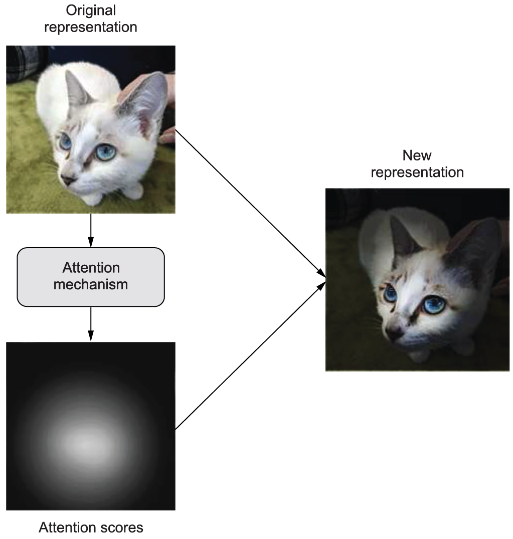

* Este tipo de mecanismo de atención se puede utilizar para **algo más que resaltar o borrar ciertas características**. Se puede usar para **hacer que las funciones sean conscientes del contexto**. 
* Recordando los **word embeddings**: **espacios vectoriales** que **capturan la "forma" de las relaciones semánticas entre diferentes palabras**. En un espacio embedding, una sola palabra tiene una posición fija, y dada por esa posición, un **conjunto fijo de relaciones** con todas las demás palabras del espacio. 
* El **significado de una palabra** en un texto específico también **depende del contexto** en ese texto. (El date de "mark the date" vs "go on a date" vs "buy a date at the market") (El see de "I'll see you soon" vs "I'll see this project to its end" vs "I see what you mean").
* Un **embedding space inteligente** proporcionaría una **representación vectorial diferente** para una palabra **dependiendo de las otras palabras** que la rodean. Ahí es donde entra la **self-attention**. Su propósito es **modular la representación de un token usando las representaciones de tokens relacionados en la secuencia**. Esto **produce representaciones de tokens conscientes del contexto**. (“The train left the station on time.” -> station -> radio station? International Space Station? -> Vamos a resolverlo algorítmicamente a través de la self-attention)

**Self-attention: los puntajes de atención se calculan entre "station" y cualquier otra palabra en la secuencia, y luego se usan para ponderar una suma de vectores de palabras que se convierte en el nuevo vector de "station"**.

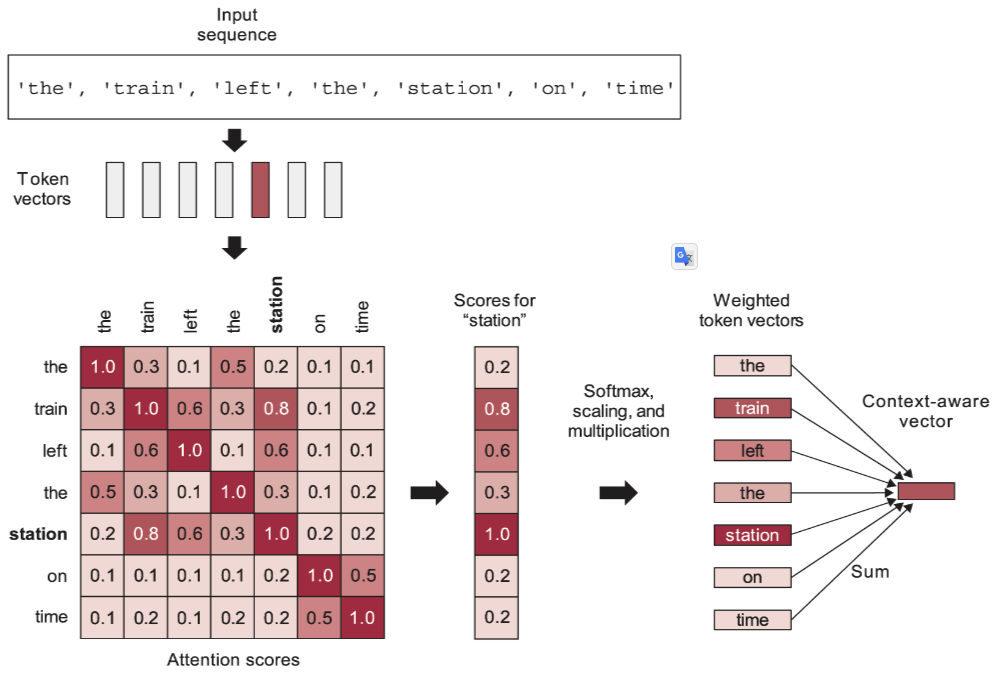

1. **PASO 1**: **Calcular las 
puntuaciones de relevancia entre el vector de "station" y cualquier otra palabra de la oración** . Estos son nuestros **“puntajes de atención” ("attention scores")**. Esto será el **producto escalar (dot product) entre dos vectores de palabras** como una **medida de la fuerza de su relación**. Es una **función de distancia muy eficiente** desde el punto de vista computacional, y ya era la forma estándar de relacionar embeddings de dos palabras entre sí mucho antes de Transformers. En la práctica, **estos puntajes también pasarán por una función de escalado y un softmax**, pero por ahora, eso es solo un detalle de implementación.
2. **PASO 2** es calcular la **suma de todos los vectores de palabras en la oración**, **ponderados por nuestros puntajes de relevancia**. Las palabras estrechamente relacionadas con "station" contribuirán más a la suma (incluida la propia palabra "estación"), mientras que las palabras irrelevantes no aportarán casi nada. El **vector resultante es nuestra nueva representación de "station"**: una **representación que incorpora el contexto circundante**. En particular, incluye parte del vector “train”, aclarando que se trata, de hecho, de una “estación de tren”.
3. Repetimos este proceso **para cada palabra de la oración**, **produciendo una nueva secuencia de vectores que codifican la oración**. Veámoslo en **pseudocódigo** similar a NumPy:

In [ ]:
def self_attention(input_sequence):
    output = np.zeros(shape=input_sequence.shape)
    # Itera sobre cada token en la secuencia de entrada
    for i, pivot_vector in enumerate(input_sequence):
        scores = np.zeros(shape=(len(input_sequence),))
        for j, vector in enumerate(input_sequence):
            # Computa el producto escalar (attention score) entre el 
            # token que estamos tratando y cada uno de los demás tokens
            scores[j] = np.dot(pivot_vector, vector.T)
        # Escalamos por un factor de normalización y aplicamos softmax
        scores /= np.sqrt(input_sequence.shape[1])
        scores = softmax(scores)
        new_pivot_representation = np.zeros(shape=pivot_vector.shape)
        for j, vector in enumerate(input_sequence):
            # Tomamos la suma de todas los tokens 
            # ponderados por los attention scores
            new_pivot_representation += vector * scores[j]
        # Esa suma es la salida
        output[i] = new_pivot_representation
    return output

Por supuesto, en la práctica usaríamos una implementación **vectorizada**. **Keras tiene una capa incorporada para manejarlo**: la capa **``MultiHeadAttention``**. Así es como se usaría:

In [ ]:
num_heads = 4 
embed_dim = 256 
mha_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
outputs = mha_layer(inputs, inputs, inputs)

Respondamos a **porqué estamos pasando las entradas a la capa tres veces** y a qué se refieren estas **Multi Head**

#### Self-attention Generalizada: El modelo consulta-clave-valor (query-key-value)

* Hasta ahora, **solo hemos considerado una secuencia de entrada**. Sin embargo, la arquitectura de Transformer se desarrolló originalmente para la **traducción automática**, en la que debe **lidiar con dos secuencias de entrada**: la **secuencia de origen** que está traduciendo actualmente (como “How’s the weather today?”) y la **secuencia de destino** que está convirtiendo. (como “¿Qué tiempo hace hoy?”). 
* Un **transformador** es un **modelo de secuencia-a-secuencia**: fue **diseñado para convertir una secuencia en otra**. Veremos los modelos de secuencia-a-secuencia con más profundidad más adelante.
* Damos un paso atrás y vemos que realiza el mecanismo de self-attention esquemáticamente:

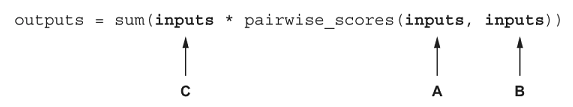

* Esto significa que "para cada token en ``inputs`` (A), calcula cuánto está relacionado el token con cada token en las ``inputs`` (B) y use estos puntajes para ponderar una suma de tokens de las ``inputs`` (C)". 
* No hay nada que requiera que A, B y C se refieran a la misma secuencia de entrada. En el **caso general, podría estar haciendo esto con tres secuencias diferentes**. 
* Los llamaremos "consulta", "claves" y "valores". La operación se convierte en **"para cada elemento de la consulta, calcula cuánto se relaciona el elemento con cada clave y use estos puntajes para ponderar una suma de valores"**:

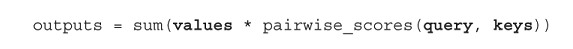

* Esta **terminología** proviene de los **motores de búsqueda** y los **sistemas de recomendación.** 
* Imagina que estás escribiendo una **consulta** para recuperar una foto de tu colección: **“dogs on the beach.”**. Internamente, **cada una de sus imágenes en la base de datos** se describe mediante un conjunto de **palabras clave**: "cat", "dog", "party", etc. Las **llamaremos "claves"**. El motor de búsqueda **comenzará comparando su consulta con las claves de la base de datos**. "dog" arroja una coincidencia de 1 y "cat" arroja una coincidencia de 0. Luego clasificará esas claves por **fuerza de coincidencia (relevancia)** y **devolverá las imágenes asociadas con las N coincidencias principales**, en orden de relevancia.

**Recuperación de imágenes de una base de datos: la "consulta" se compara con un conjunto de "claves" y las puntuaciones de coincidencia se utilizan para clasificar los "valores" (imágenes).**

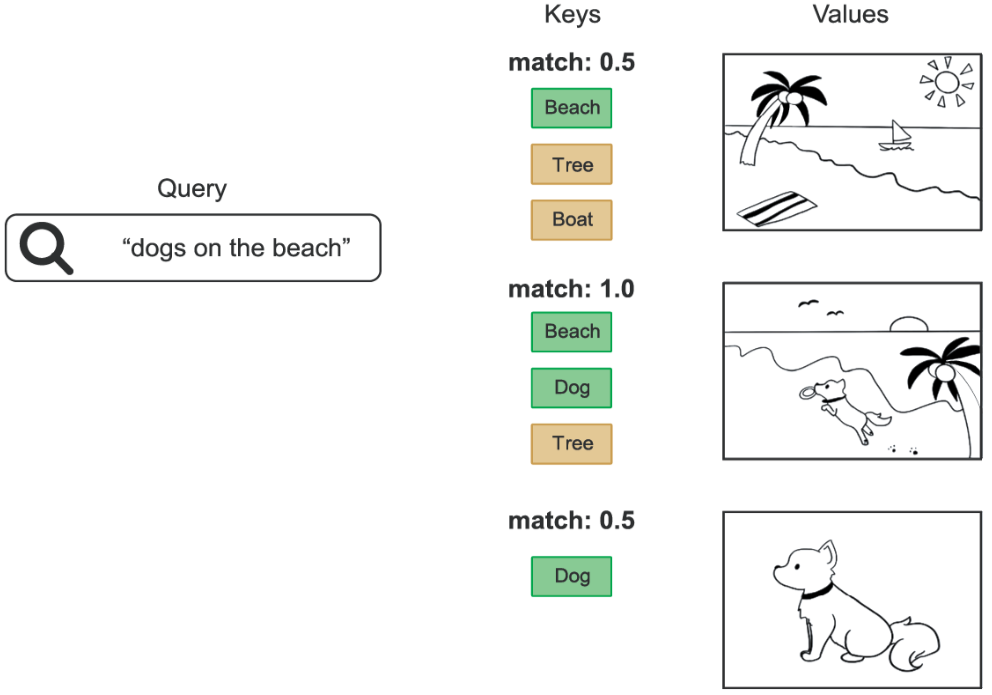

* Conceptualmente, **esto es lo que está haciendo la attention al estilo de Transformer**. Tiene una **secuencia de referencia que describe algo que está buscando: la consulta**. Tenemos un **cuerpo de conocimiento del que estámos tratando de extraer información: los valores**. **A cada valor se le asigna una clave que describe el valor en un formato que se puede comparar fácilmente con una consulta**. Simplemente **se hace coincidir la consulta con las claves**. Luego **devuelve una suma ponderada de valores**.
* En la práctica, **las claves y los valores suelen ser la misma secuencia**. En la **traducción** automática, por ejemplo, la **consulta** sería la **secuencia de destino**, y la **secuencia de origen** desempeñaría los roles de **claves y valores**: para cada elemento del destino (como "tiempo"), desea volver a la fuente (“How’s the weather today?”) e identificar los diferentes bits que están relacionados con él (“tiempo” y “weather” deben tener una fuerte coincidencia). Y, naturalmente, **si solo estamos clasificando secuencias, la consulta, las claves y los valores son todos iguales**: **estamos comparando una secuencia consigo misma, para enriquecer cada token con el contexto de toda la secuencia**.

Eso explica por qué necesitábamos pasar las ``inputs`` tres veces a nuestra capa ``MultiHeadAttention``. Pero, ¿por qué atención de "múltiples cabezas"?

### Multi-head attention

* La "atención de múltiples cabezas" (**“Multi-head attention”**) es un **ajuste adicional** al mecanismo de self-attention, introducido en “Attention is all you need.”. 
* El apodo de "múltiples cabezas" se refiere al hecho de que **el espacio de salida de la capa de self-attention se factoriza en un conjunto de subespacios independientes**, que **se aprenden por separado**: la **consulta inicial**, la **clave** y el **valor** se **envían a través de tres conjuntos independientes de proyecciones densas**, **resultando en tres vectores separados**. 
* **Cada vector se procesa a través de la neural attention**, y **las diferentes salidas se concatenan nuevamente en una sola secuencia de salida**. **Cada uno de esos subespacios se denomina "head"**.

**La capa ``MultiHeadAttention``**

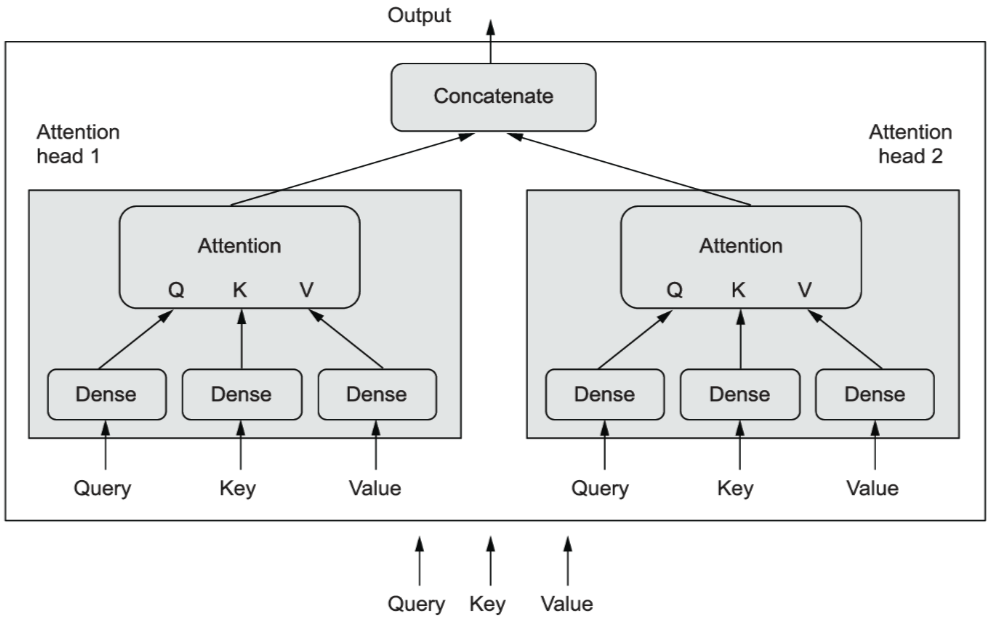

* La presencia de **proyecciones densas que se pueden aprender permite que la capa realmente aprenda algo**, en lugar de ser una transformación puramente sin estado que requeriría capas adicionales antes o después para ser útil. Además, **tener cabezas independientes ayuda a la capa a aprender diferentes grupos de características para cada token**, donde las **características dentro de un grupo están correlacionadas entre sí**, pero en su mayoría son independientes de las características de un grupo diferente.

* Esto es similar en principio a lo que hace que funcionen las capas convolucionales separables en profundidad: en una convolución separable en profundidad, el espacio de salida de la convolución se factoriza en muchos subespacios (uno por canal de entrada) que se aprenden de forma independiente. El paper "Attention is all you need” se escribió en un momento en que se demostró que la idea de factorizar espacios de características en subespacios independientes proporciona grandes beneficios para los modelos de visión por computadora, tanto en el caso de convoluciones separables en profundidad como en el caso de un enfoque estrechamente relacionado, capas convolucionales agrupadas. Multi-head attention es simplemente la aplicación de la misma idea a la self-attention.

### El Transformer encoder

* Vista su utilidad, **agregamos proyecciones densas extras (una o dos) a la salida del mecanismo de atención**
* Como **nuestro modelo está comenzando a hacer mucho, agregaremos conexiones residuales para asegurarnos de no destruimos ninguna información valiosa** (se ve en deep learning avanzado para visión por computador) en el camino (imprescindibles para cualquier arquitectura lo suficientemente profunda). 
* Agregamos **capas de normalización, que ayudan a que los gradientes fluyan mejor durante la retropropagación** (se ve en deep learning avanzado para visión por computador). 

Proceso de pensamiento que imaginamos que desarrollaron los inventores de la arquitectura Transformer: **Factorizar salidas en múltiples espacios independientes**, **agregar conexiones residuales**, **agregar capas de normalización**: todos estos son **patrones de arquitectura estándar que sería conveniente aprovechar en cualquier modelo complejo**. Juntas, forman el **Transformer Encoder**, **una de las dos partes críticas que conforman la arquitectura de Transformer**

**El ``TransformerEncoder`` encadena una capa ``MultiHeadAttention`` con una proyección densa y agrega normalización, así como conexiones residuales.**

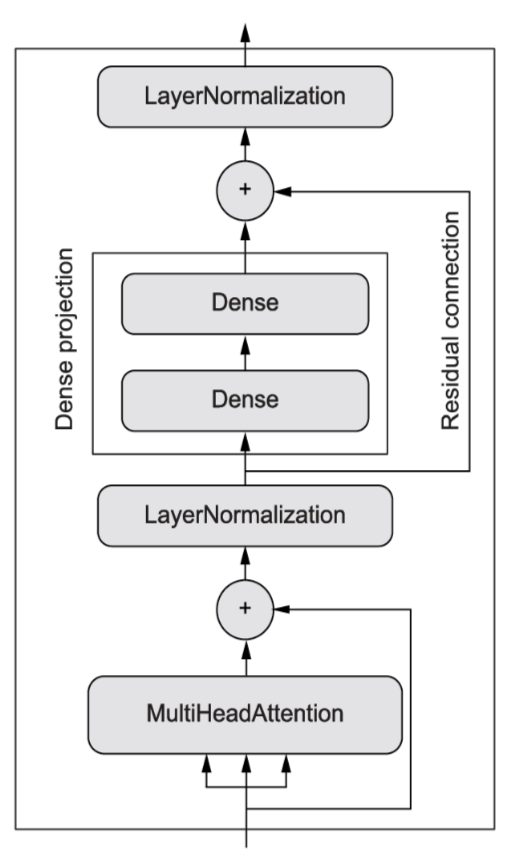

La **arquitectura original de Transformer** consta de **dos partes**: 
1. Un **Transformer Encoder que procesa la secuencia de origen** 
2. Un  **Transformer Decoder** que **utiliza la secuencia de origen para generar una versión traducida**. 

Fundamentalmente, **la parte del codificador se puede usar para la clasificación de texto**: es un **módulo muy genérico que ingiere una secuencia y aprende a convertirla en una representación más útil**. 

Procedemos a implementar un  Transformer Encoder y los probaremos en la tarea de clasificación de opiniones de reseñas de películas.

**Obtenemos los datos**

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  26.9M      0  0:00:02  0:00:02 --:--:-- 26.9M


**Preparamos los datos**

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Found 25000 files belonging to 2 classes.


**Vectorizamos los datos**

In [ ]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

**Transformer Encoder implementado como una subclase de `Layer`**

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        # Tamaño de los vectores de los tokens de entrada
        self.embed_dim = embed_dim
        # Tamaño de la capa densa interna
        self.dense_dim = dense_dim
        # Número de attention heads
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    # El cálculo va en call()
    def call(self, inputs, mask=None):
        # La máscara que generará la capa Embedding 
        # será 2D, pero la capa de atención espera 
        # ser 3D o 4D, por lo que ampliamos su rango
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    # Implementamos la serialización para 
    # que podamos guardar el modelo
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

**GUARDAR CAPAS PERSONALIZADAS**

* Cuando escribamos **capas personalizadas**, debemos asegurarnos de **implementar el método ``get_config``**: esto permite que la capa se vuelva reinstanciar desde su diccionario config, lo cual es útil durante el guardado y la carga del modelo. 
* El **método debe devolver un diccionario Python que contenga los valores de los argumentos del constructor utilizados para crear la capa**.

Todas las capas de Keras se pueden serializar y deserializar de la siguiente manera:

In [ ]:
config = layer.get_config()
# La configuración no contiene valores 
# de peso, por lo que todos los pesos 
# en la capa se inicializan desde cero.
new_layer = layer.__class__.from_config(config)

Por ejemplo:

In [ ]:
layer = PositionalEmbedding(sequence_length, input_dim, output_dim)
config = layer.get_config()
new_layer = PositionalEmbedding.from_config(config)

* Al guardar un modelo que contiene capas personalizadas, el **archivo guardado contendrá estos diccionarios de configuración**. 
* Al cargar el modelo desde el archivo, **debemos proporcionar las clases de capa personalizadas al proceso de carga**, para que pueda dar sentido a los objetos de configuración:

In [ ]:
model = keras.models.load_model(
    filename, custom_objects={"PositionalEmbedding": PositionalEmbedding})

* Las **capas de normalización que estamos usando aquí no son capas de normalización por lotes** como las que hemos usado antes en los modelos de imagen. Eso es porque **BatchNormalization no funciona bien para datos secuenciales**. 
* En cambio, estamos usando la capa **``LayerNormalization``**, que **normaliza cada secuencia independientemente de otras secuencias en el lote**. Así, en pseudocódigo similar a NumPy:

In [ ]:
# Forma de la entrada: (batch_size, sequence_length, embedding_dim)
def layer_normalization(batch_of_sequences):
    # Para calcular la media y la varianza, solo 
    # agrupamos datos sobre el último eje (eje -1)
    mean = np.mean(batch_of_sequences, keepdims=True, axis=-1)
    variance = np.var(batch_of_sequences, keepdims=True, axis=-1)
    return (batch_of_sequences - mean) / variance

Comparado con **``BatchNormalization``** (durante el entrenamiento):

In [ ]:
# Forma de la entrada: (batch_size, height, width, channels)
def batch_normalization(batch_of_images):
    # Agrupa los datos sobre el eje del lote (eje 0), 
    # lo que crea interacciones entre las muestras en un lote.
    mean = np.mean(batch_of_images, keepdims=True, axis=(0, 1, 2))
    variance = np.var(batch_of_images, keepdims=True, axis=(0, 1, 2))
    return (batch_of_images - mean) / variance

Mientras que la ``BatchNormalization`` recopila información de muchas muestras para obtener estadísticas precisas para las medias de características y las varianzas, ``LayerNormalization`` agrupa los datos dentro de cada secuencia por separado, lo que es más apropiado para los datos de tipo secuencia.

Ahora que hemos implementado nuestro ``TransformerEncoder``, podemos usarlo para ensamblar un modelo de clasificación de texto similar al basado en GRU que ya vimos

**Usando el Transformer encoder para clasificación de texto**

In [ ]:
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 transformer_encoder (Transf  (None, None, 256)        543776    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257   

**Entrenamos y evaluamos el modelo basado en Transformer Encoder**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/20
625/625 [==============================] - 91s 133ms/step - loss: 0.5016 - accuracy: 0.7684 - val_loss: 0.3785 - val_accuracy: 0.8224
Epoch 2/20
625/625 [==============================] - 58s 93ms/step - loss: 0.3433 - accuracy: 0.8533 - val_loss: 0.3065 - val_accuracy: 0.8686
Epoch 3/20
625/625 [==============================] - 50s 80ms/step - loss: 0.3069 - accuracy: 0.8709 - val_loss: 0.3119 - val_accuracy: 0.8684
Epoch 4/20
625/625 [==============================] - 50s 81ms/step - loss: 0.2765 - accuracy: 0.8866 - val_loss: 0.2962 - val_accuracy: 0.8738
Epoch 5/20
625/625 [==============================] - 49s 78ms/step - loss: 0.2456 - accuracy: 0.9033 - val_loss: 0.2907 - val_accuracy: 0.8756
Epoch 6/20
625/625 [==============================] - 50s 80ms/step - loss: 0.2120 - accuracy: 0.9159 - val_loss: 0.2858 - val_accuracy: 0.8806
Epoch 7/20
625/625 [==============================] - 47s 75ms/step - loss: 0.1846 - accuracy: 0.9277 - val_loss: 0.2825 - val_accuracy

Alcanza una **precisión de prueba del 87.5%, algo peor que el modelo GRU**.

**¿Qué está pasando?**

* Estamos centrados en "modelos de secuencia" por la importancia del orden de las palabras. 
* Dije que **Transformer** era una **arquitectura de procesamiento de secuencias**, desarrollada originalmente para la traducción automática.
* Lo cierto es que **todavía**, el **Transformer Encoder que acabamos de ver en acción no es, en absoluto, un modelo de secuencia**: Se compone de **capas densas que procesan la secuencia tokens independientemente entre sí**, y una **capa de self-attention que considera los tokens como un conjunto**. 
* Podríamos cambiar el orden de los tokens en una secuencia, y obtendríamos exactamente los mismos puntajes de pairwaise attention y exactamente las mismas representaciones context-aware. 
* La self-attention es un **mecanismo de procesamiento, centrado en las relaciones entre pares de elementos de secuencia**, es ciega a si estos elementos ocurren al principio, al final o en el medio de una secuencia. Entonces, ¿por qué decimos que Transformer es un modelo de secuencia? ¿Y cómo podría ser bueno para la traducción automática si no mira el orden de las palabras?

**Características de los diferentes tipos de modelos PLN**

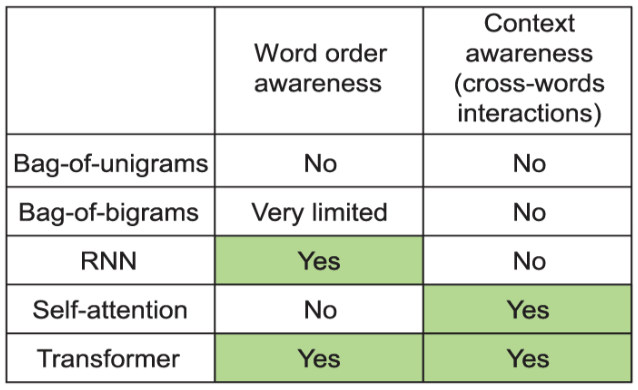

En realidad, el **Transformador es un enfoque híbrido que técnicamente es agnóstico de orden**, pero que **inyecta la información del orden manualmente en las representaciones que procesa**. ESTO ES LO QUE NOS FALTABA: se llama codificación posicional (**positional encoding**)

#### Usando codificación posicional (positional encoding) para re-inyectar información de orden

* Para **darle acceso al modelo a la información de orden de palabras**, vamos a **agregar la posición de la palabra en la oración a cada word-embedding**.
* Nuestras **word-embeddings de entrada** tendrán **dos componentes**: el **vector de palabra habitual**, que representa la palabra independientemente de cualquier contexto específico, y un **vector de posición**, que **representa la posición de la palabra en la oración actual**. Con suerte, **el modelo descubrirá cómo aprovechar mejor esta información** adicional.
* Lo **más simple**: **concatenar** la **posición de la palabra** a nuestro **vector de embedding**. Agregaríamos un **eje de "posición" al vector** y lo llenaría con 0 para la primera palabra en la secuencia, 1 para la segunda, y así sucesivamente. **No es ideal**, porque las **posiciones pueden ser integers muy grandes**, lo que interrumpirá el rango de valores en el vector de embedding (a las redes neuronales no les gustan los valores de entrada muy grandes).
* El paper “Attention is all you need” presenta un truco interesante para **codificar las posiciones de las palabras**: se **agregó a la word-embedding un vector que contiene valores en el rango ``[-1, 1]``** que **variaba cíclicamente dependiendo de la posición** (usaba **funciones de coseno** para lograr esto). 
* Este truco ofrece una forma de caracterizar de manera única cualquier entero en un rango grande a través de un vector de valores pequeños. Es inteligente, pero no es lo que vamos a usar en nuestro caso. 
* **Haremos algo más simple y efectivo**: **aprenderemos vectores de embedding de posición de la misma manera que aprendemos a incrustar los índices de palabras**. Luego procederemos a **agregar nuestros embeddings de posición a las word-embeddings correspondientes, para obtener una word-embedding consciente de la posición** (position-aware word-embedding). Esta técnica se llama "incrustación posicional" (**positional embedding**) . Vamos a implementarlo:

**Implementando incrustación posicional (positional embedding) como una subclase de capa (layer)**

In [ ]:
class PositionalEmbedding(layers.Layer):
    # Una desventaja de las incrustaciones de posición es que 
    # la longitud de la secuencia debe conocerse de antemano
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        # Prepara una capa de embedding para los índices de token.
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            # Y otro para las posiciones te tokens
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        # Agrega ambos vectores embeddings juntos
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        # Al igual que la capa de embedding, 
        # esta capa debería poder generar una 
        # máscara para que podamos ignorar los 
        # ceros de relleno en las entradas. 
        # El framework llamará automáticamente 
        # al método compute_mask y la máscara 
        # se propagará a la siguiente capa.
        return tf.math.not_equal(inputs, 0)

    # Implementamos la serialización para que 
    # podamos guardar el modelo.
    def get_config(self):
        config = super().get_config()
        # config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

Utilizaría esta capa ``PositionEmbedding``, al igual que una capa ``Embedding`` normal. ¡Veamoslo en acción!

#### Poniéndolo todo junto: Un Transformer de Clasificación de Texto

Todo lo que tenemos que hacer para **comenzar a tener en cuenta el orden de las palabras** es intercambiar la antigua capa ``Embedding`` con nuestra versión consciente de la posición (position-aware).

**Combinando el  Transformer encoder con incrustación posicional (positional embedding)**

In [ ]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
# ESTE ES EL CAMBIO
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        5273600   
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder_1 (Tran  (None, None, 256)        543776    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                           

Llegamos a la **precisión de la prueba del 88.3%**, una **mejora sólida que demuestra claramente el valor de la información del orden de las palabras para la clasificación de texto**. **¡Este es nuestro mejor modelo de secuencia hasta ahora! Sin embargo, todavía está una poco debajo del enfoque de la bolsa de las palabras**.

### Cuando usar un modelo de secuencia sobre un modelo de bolsa-de-palabras

Es **posible que escuchéis que los métodos de la bolsa de palabras están desactualizados**, y que **los modelos de secuencia basados en transformadores son el camino a seguir**, **sin importar qué tarea o conjunto de datos** esté viendo. Este definitivamente **no es el caso**: **una pequeña pila de capas densas sobre una bolsa de bigramas sigue siendo un enfoque perfectamente válido y relevante en muchos casos**. De hecho, entre las diversas técnicas que hemos probado en el conjunto de datos IMDB a lo largo de este capítulo, **¡el mejor desempeño hasta ahora fue la bolsa de bigramas!**

Entonces, **¿cuándo debe preferir un enfoque sobre el otro?**

Análisis sistemático del rendimiento de varias técnicas de clasificación de texto en muchos tipos diferentes de conjuntos de datos de texto hecho en 2017: **regla general notable y sorprendente para decidir si ir con una bolsa de palabras modelo o un modelo de secuencia:**

* Debemos prestar mucha atención a la **relación entre el número de muestras en nuestros datos de entrenamiento y el número medio de palabras por muestra**. 
  * Si **relación pequeña** (< 1.500), -> **funcionará mejor con bolsa de bigramas** **y será mucho más rápido entrenar**. 
  * Si **relación > 1.500**, **funciona mejor con modelo de secuencia**. 

En otras palabras, **los modelos de secuencia funcionan mejor cuando hay muchos datos de entrenamiento disponibles y cuando cada muestra es relativamente corta**.

**Una heurística simple para seleccionar un modelo de clasificación de texto: la relación entre el número de muestras de entrenamiento y el número medio de palabras por muestra**

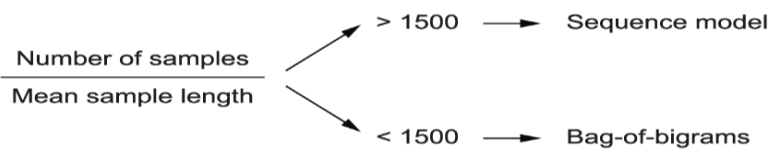

* Entonces, si estamos clasificando documentos de **1.000 palabras de largo**, y tenemos **100.000 de estos documentos** (una relación de 100), debemor ir con un **modelo bigrama**. 
* Si estamos clasificando tweets que tienen 40 palabras de largo en promedio, y tenemos 50.000 tweets (una relación de 1,250), también debemos ir con un modelo Bigrama. 
* Pero si aumentamos el tamaño de nuestro conjunto de datos a 500.000 tweets (una relación de 12.500), es mejor ir con un **codificador de transformador.** 
* ¿Qué pasa con la tarea de clasificación de revisión de películas IMDB? Tuvimos 20.000 muestras de entrenamiento y un recuento promedio de palabras de 233, por lo que nuestra regla general apunta hacia un modelo bigrama, que confirma lo que encontramos en la práctica.

Esto **intuitivamente tiene sentido**: la entrada de un **modelo de secuencia representa un espacio más rico y complejo** y, por lo tanto, **se necesita más datos para mapear ese espacio**; Mientras tanto, un **conjunto simple de términos** es un **espacio tan simple que se puede entrenar utilizando solo unos pocos cientos o miles de muestras**. 

Además, **cuanto más corta sea una muestra, menos se puede permitir el modelo descartar cualquiera de la información que contiene**, en particular, **el orden de las palabras se vuelve más importante y descartarla puede crear ambigüedad**. 

Las oraciones "This movie is the bomb" y "This movie was the bomb" tienen representaciones de tipo unigrama muy cercanas, lo que podría confundir un modelo de bolsa de palabras, pero un modelo de secuencia podría decir cuál es negativo y cuál es positivo. Con una muestra más larga, las estadísticas de palabras serían más confiables y el tema o sentimiento sería más evidente solo con el histograma de palabras.

Ahora, tenéis que terner en cuenta que **esta regla heurística se desarrolló específicamente para la clasificación de texto**. Es posible que **no necesariamente se mantenga para otras tareas de PLN**, cuando se trata de la **traducción automática**, por ejemplo, el **Transformer brilla especialmente para secuencias muy largas, en comparación con los RNN**. Nuestra **heurística también es solo una regla general**, en lugar de una ley científica, así que podéis esperar que funcione la mayor parte del tiempo, pero no necesariamente siempre.

## Más allá de la clasificación de textos: Aprendizaje de Secuencia-a-Secuencia

Tenemos todas las herramientas para resolver cualquier problema de PLN, aunque solo lo hemos usado en **Clasificación de Textos**.

**Modelo de secuencia-a-secuencia**: **entrada: secuencia** (oración o párrafo) **salida: traducción a una secuencia diferente**.:

* **Traducción automática**: idioma origen -> idioma de destino.
* **Resumen de texto**: documento largo -> versión más corta que conserve la información más importante.
* **Respuesta a preguntas**: pregunta -> respuesta.
* **Chatbots**: mensaje de diálogo -> respuesta al mensaje || historial de una conversación -> la siguiente respuesta de la conversación.
* **Generación de texto**: mensaje de texto -> párrafo que complete el mensaje.
* Etc.

Modelos de **secuencia-a-secuencia**: Durante el **entrenamiento** se caracterizan por: 
* Un **codificador (encoder)** convierte la secuencia de **entrada** ->  **representación intermedia**.
* Se **entrena un decodificador (decoder)** para **predecir el siguiente token** ``i`` en la **secuencia de destino observando**:
  * **Tokens anteriores ``(0 a i - 1)``** 
  * La **secuencia de origen codificada**.

**Aprendizaje de secuencia-a-secuencia: el codificador procesa la secuencia fuente y luego la envía al decodificador. El decodificador mira la secuencia objetivo hasta el momento y predice la secuencia objetivo compensada por un paso en el futuro. Durante la inferencia, generamos un token de destino a la vez y lo devolvemos al decodificador.**

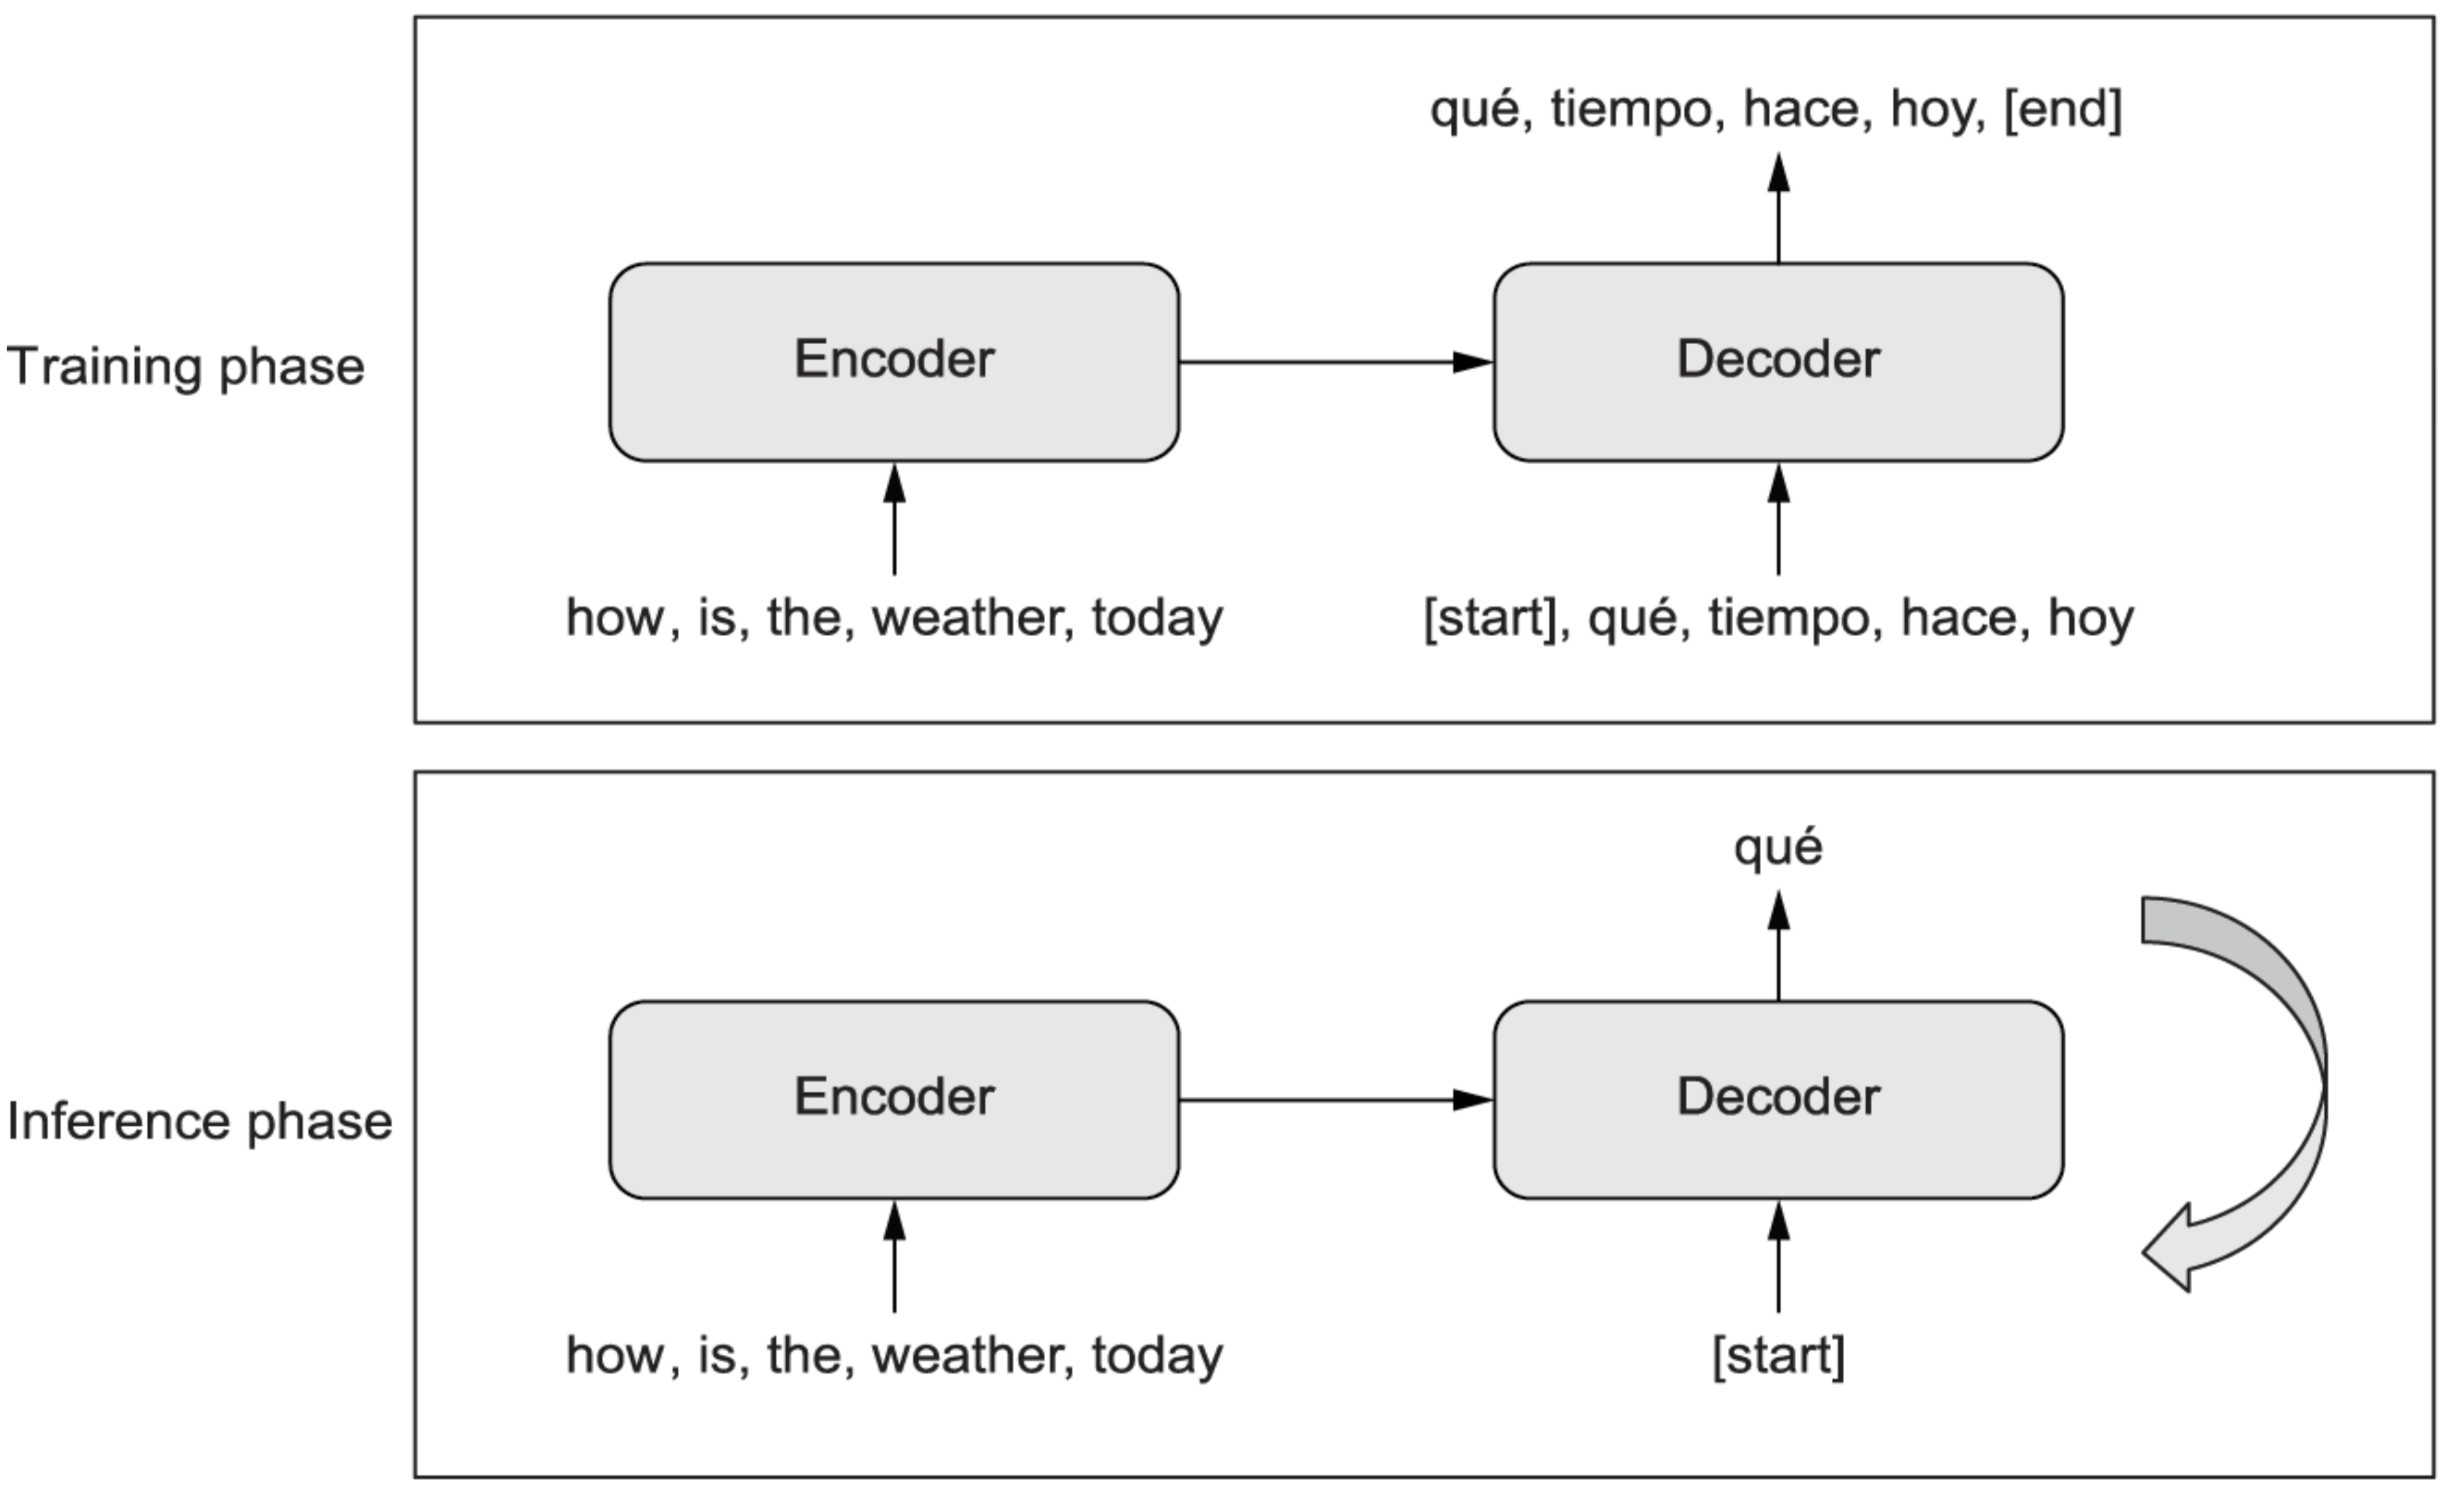

Durante la **inferencia**, no tenemos acceso a la secuencia objetivo, estamos tratando de **predecirla desde cero**. Tendremos que **generarla token a token**:

1. Obtenemos la **secuencia origen codificada del codificador**.
2. El **decodificador** comienza **observando** la **secuencia original codificada**, así como un **token "semilla" inicial** (**``"[start]"``**), y **los usa para predecir el primer token en la secuencia**.
3. La **secuencia pronosticada hasta el momento se retroalimenta al decodificador, que genera el siguiente token, y así sucesivamente, hasta que genera un token de parada (``"[end]"``)**.

### Un ejemplo de máquina de traducción

Haremos modelado de **secuencia-a-secuencia en una tarea de traducción automática** (para lo que se creó Transformer). Lo veremos:
1. Con modelo de secuencia recurrente **RNN**
2. Arquitectura completa de **Transformer**.

Trabajaremos con un conjunto de datos de traducción de inglés a español disponible en www.manythings.org/anki/. Vamos a descargarlo:

In [1]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2023-03-07 22:09:50--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.01s   

2023-03-07 22:09:50 (201 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



El archivo contiene un ejemplo por línea: una **oración en inglés + tabulador + la oración en español** correspondiente. Analicemos este archivo.

In [2]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
# Itera sobre las líneas en el archivo
for line in lines:
    # Cada línea contiene una frase en inglés y su 
    # traducción al español, separadas por tabuladores.
    english, spanish = line.split("\t")
    # Anteponemos "[start]" y añadimos "[end]" 
    # a la oración en español, para que coincida 
    # con la plantilla de la figura anterior
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

Nuestros ``text_pairs`` se ven así:

In [3]:
import random
print(random.choice(text_pairs))

('The plane landed at Narita.', '[start] El avión aterrizó en Narita. [end]')


Los **mezclamos** y **dividirlos** en los **conjuntos** habituales de **entrenamiento**, **validación** y **prueba**.

In [4]:
import random
random.shuffle(text_pairs)
# 15% validación
num_val_samples = int(0.15 * len(text_pairs))
# 70% entrenamiento
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
# 15% test o pruebas
test_pairs = text_pairs[num_train_samples + num_val_samples:]

Preparamos **dos capas de ``TextVectorization``** separadas: una para **inglés** y otra para **español**. **Personalizamos** la forma en que se **preprocesan las cadenas**:

* Necesitamos **conservar los tokens ``"[start]"`` y ``"[end]"``** que hemos insertado. De forma predeterminada, los caracteres ``[`` y ``]`` se quitarían, pero queremos mantenerlos para poder distinguir la palabra "start" y el token de inicio ``"[start]"``.
* Los **signos de puntuación** son **diferentes en cada idioma**. En la capa de ``TextVectorization`` en español, si vamos a eliminar los caracteres de puntuación, también debemos eliminar el carácter ``¿``

Hay que tener en cuenta que para un modelo de traducción "serio" trataríamos los caracteres de puntuación como tokens separados en lugar de eliminarlos. En nuestro caso, por simplicidad, nos desharemos de todos los signos de puntuación.

**Vectorización de los pares de texto en inglés y español**

In [5]:
import tensorflow as tf
import string
import re
from tensorflow.keras import layers

# Prepara una función de estandarización de cadenas 
# personalizada para la capa TextVectorization en 
# español: conserva [ y ] pero elimina ¿ (así como 
# todos los demás caracteres de cadenas.puntuación)
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

# Para mantener las cosas simples, solo veremos las 
# 15.000 palabras principales en cada idioma y 
# restringiremos las oraciones a 20 palabras.
vocab_size = 15000
sequence_length = 20

# La capa en Inglés
source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
# La capa en Español
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    # Generamos oraciones en español que tengan un token 
    # adicional, ya que necesitaremos compensar la oración 
    # en un paso durante el entrenamiento
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
# Aprende el vocabulario de cada idioma
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

Finalmente, podemos **convertir** nuestros **datos** en una **tubería ``tf.data``**. Queremos que **devuelva una tupla ``(inputs, target)``** donde **``inputs``** es un **dict** con **dos claves**, **"encoder_inputs" (la oración en inglés)** y **"decoder_inputs" (la oración en español)**, y **``target`` es la oración en español con un offset de un paso** adelante

**Preparando los datasets para la tarea de traducción**

In [6]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        # La oración de entrada en español 
        # no incluye el último token para 
        # mantener las entradas y los 
        # objetivos en la misma longitud.
        "spanish": spa[:, :-1],
    # La frase objetivo en español está un 
    # paso por delante. Ambos siguen siendo 
    # de la misma longitud (20 palabras)
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    # Utilizamos el almacenamiento en caché en memoria 
    # para acelerar el preprocesamiento
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Así es como se ven los resultados de nuestro conjunto de datos:

In [7]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


Los datos ya están listos: es hora de construir algunos modelos. Comenzaremos con un modelo recurrente de secuencia a secuencia antes de pasar a un Transformador.

### Aprendizaje de Secuencia-a-Secuencia con RNNs

RNNs dominaron el aprendizaje de secuencia-a-secuencia entre 2015 y 2017 antes de ser superadas por Transformer. (En 2017 Google Translate  funcionaba con una pila de siete grandes capas LSTM)

La **forma** más **simple** e ingenua de **usar RNN** para **convertir una secuencia en otra** secuencia es **mantener la salida de RNN en cada timestep**. En Keras, se vería así:

In [ ]:
inputs = keras.Input(shape=(sequence_length,), dtype="int64")
x = layers.Embedding(input_dim=vocab_size, output_dim=128)(inputs)
x = layers.LSTM(32, return_sequences=True)(x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model(inputs, outputs)

Dos **problemas principales con este enfoque**:

* La **longitud de la secuencia de destino** siempre **debe ser igual** a la de **origen** (no suele ser el caso, aunque se puede solventar con relleno).
* Tal y como funcionan las RNN, el **modelo solo observará los tokens 0...N en la secuencia de origen para predecir el token N en la secuencia de destino**. Esto lo hace **inadecuada para la mayoría de las tareas** y, en particular, para la traducción. Considere traducir “The weather is nice today” al francés; eso sería "Il fait beau aujourd'hui". Tendría que ser capaz de predecir "Il" solo con "The", "Il fait" solo con "The weather", etc., lo cual es simplemente imposible.

Si fueras un **traductor humano**, **comenzarías leyendo la oración fuente completa antes de comenzar a traducirla**. Esto es especialmente importante si se trata de **idiomas** que tienen un **orden de palabras muy diferente**, como el inglés y el japonés. Y **eso es exactamente lo que hacen los modelos estándar de secuencia-a-secuencia**.

En una **configuración adecuada de secuencia-a-secuencia** usaremos **un RNN (el codificador)** para **convertir toda la secuencia fuente en un solo vector** (o conjunto de vectores).  Luego, **usaríamos este vector (o vectores) como el estado inicial de otro RNN (el decodificador)**, que **observaría los elementos 0...N en la secuencia objetivo** e **intentaría predecir el paso N+1 en la secuencia objetivo**.

**Una RNN de secuencia-a-secuencia: se usa un codificador RNN para producir un vector que codifica la secuencia origen completa, que se usa como estado inicial para un decodificador RNN**

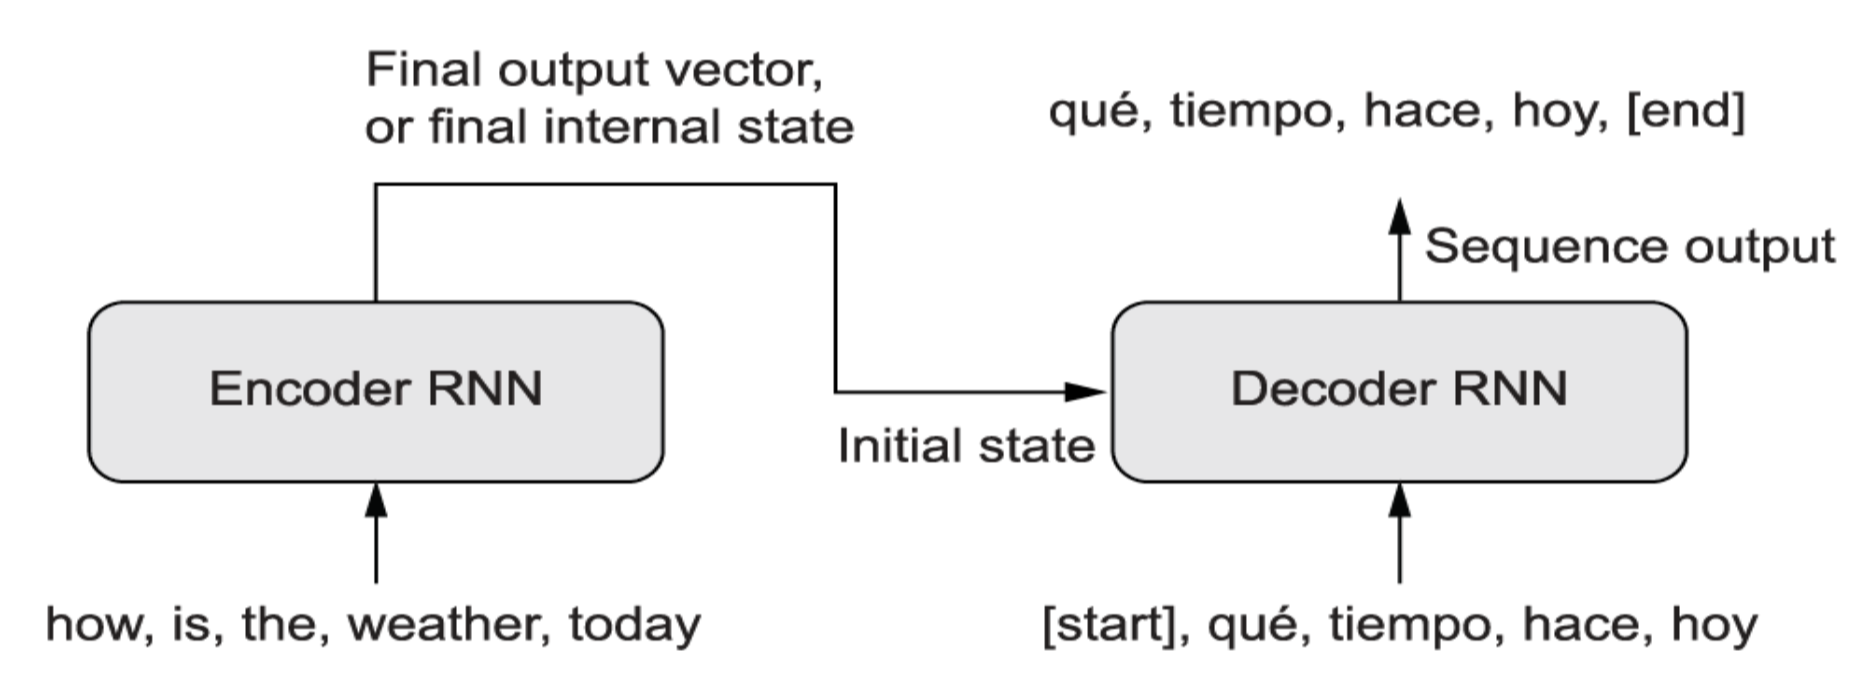

Implementemos esto en **Keras** con **codificadores** y **decodificadores** basados ​​en **GRU**. La **elección de GRU en lugar de LSTM simplifica** un poco las cosas, ya que **GRU solo tiene un vector de estado único**, mientras que LSTM tiene varios. Comencemos con el **codificador**.

**Encoder basado en GRU**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 256
latent_dim = 1024

# La oración fuente en inglés va aquí. Especificar el nombre de la 
# entrada nos permite fit() (ajustar) el modelo con un dict de entradas
source = keras.Input(shape=(None,), dtype="int64", name="english")
# No olvidemos el enmascaramiento: es fundamental en esta configuración.
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(
    # Nuestra oración fuente codificada es la 
    # última salida de un GRU bidireccional.
    layers.GRU(latent_dim), merge_mode="sum")(x)

Ahora, **agreguamos el decodificador**: una **capa GRU simple** que **toma como su estado inicial** la **oración original codificada**. Además, **agregamos una capa ``Dense``** que **produce para cada paso de salida** una **distribución de probabilidad sobre el vocabulario en español**.

**Decodificador basado en GRU y el modelo de extremo-a-extremo**



In [ ]:
# La oración objetivo en español va aquí
past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")
# No olvidar enmascarar
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
# La oración fuente codificada sirve como el estado 
# inicial del decodificador GRU.
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
# Predice el siguiente token
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)
# Modelo de extremo a extremo: mapea la oración de origen y la oración 
# de destino a la oración de destino un paso en el futuro
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

Durante el **entrenamiento**, el **decodificador** toma como **entrada** la **secuencia objetivo completa**, pero **gracias a la naturaleza paso-a-paso de los RNN**, solo **mira los tokens 0...N en la entrada** para **predecir el token N en la salida** (que corresponde al **siguiente token en la secuencia**, ya que la salida tiene un offset de un paso). Esto significa que **solo usamos información del pasado para predecir el futuro**.

Empezamos a entrenar:

**Entrenamiento de nuestro modelo recurrente de secuencia-a-secuencia**

In [ ]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
1302/1302 [==============================] - 151s 101ms/step - loss: 4.6857 - accuracy: 0.3188 - val_loss: 3.9242 - val_accuracy: 0.3878
Epoch 2/15
1302/1302 [==============================] - 114s 88ms/step - loss: 3.7290 - accuracy: 0.4150 - val_loss: 3.2546 - val_accuracy: 0.4707
Epoch 3/15
1302/1302 [==============================] - 123s 95ms/step - loss: 3.2158 - accuracy: 0.4723 - val_loss: 2.8841 - val_accuracy: 0.5168
Epoch 4/15
1302/1302 [==============================] - 112s 86ms/step - loss: 2.8586 - accuracy: 0.5123 - val_loss: 2.6412 - val_accuracy: 0.5486
Epoch 5/15
1302/1302 [==============================] - 112s 86ms/step - loss: 2.5854 - accuracy: 0.5449 - val_loss: 2.4397 - val_accuracy: 0.5789
Epoch 6/15
1302/1302 [==============================] - 112s 86ms/step - loss: 2.3636 - accuracy: 0.5725 - val_loss: 2.3273 - val_accuracy: 0.5955
Epoch 7/15
1302/1302 [==============================] - 112s 86ms/step - loss: 2.1782 - accuracy: 0.5971 - val_loss: 

* **Precisión del 64%**: en promedio, el modelo predice correctamente la siguiente palabra en la oración en español el 64% de las veces.
* **La precisión del siguiente token no es una gran métrica para los modelos de traducción automática**: asume que los tokens de destino correctos de 0 a N ya se conocen al predecir el token N + 1. En realidad, **durante la inferencia, está generando la oración de destino desde cero y no puede confiar en que los tokens generados previamente sean 100% correctos**. 
* Por último, **usamos nuestro modelo para la inferencia**. Seleccionamos **algunas oraciones en el conjunto de prueba** y **verificamos cómo las traduce nuestro modelo**. 
  * **Comenzamos con el token inicial ``"[start]"``**, y lo **introducimos** en el **modelo del decodificador**, junto con la **oración fuente codificada en inglés**. 
  * **Recuperaremos una predicción del próximo token** y la **reinyectaremos en el decodificador repetidamente**, **muestreando un nuevo token de destino en cada iteración**, **hasta** que lleguemos a **``"[end]"``** o alcancemos la longitud máxima de la oración.

**Traducir nuevas oraciones con nuestro codificador y decodificador RNN**

In [ ]:
import numpy as np
# Preparamos un dict para convertir predicciones 
# de índice de token en tokens de cadena.
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    # token semilla
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        # Muestra el siguiente token
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        # Convertimos la siguiente predicción del token en 
        # una cadena y la agregamos a la oración generada.
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        # Condición de salida: alcanzamos la longitud máxima 
        # o muestreamos un carácter de parada
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
I doubt Tom would agree.
1/1 [==============================] - 0s 23ms/step
[start] dudo que tom estaría de acuerdo [end]
-
Tom is someone who can't be trusted.
1/1 [==============================] - 0s 75ms/step
[start] tom es alguien que no puede confiar [end]
-
You're smart.
1/1 [==============================] - 0s 34ms/step
[start] eres inteligente [end]
-
He's feeling much better.
1/1 [==============================] - 0s 34ms/step
[start] Él se siente mucho mejor [end]
-
It was magic.
1/1 [==============================] - 0s 26ms/step
[start] fue [UNK] [end]
-
I had a great time here.
1/1 [==============================] - 0s 24ms/step
[start] yo tuve un buen lugar aquí [end]
-
The family ate dinner together.
1/1 [==============================] - 0s 26ms/step
[start] la familia está [UNK] después de comer [end]
-
Even idiots can give good advice.
1/1 [==============================] - 0s 23ms/step
[start] incluso los [UNK] puede ser muy buena [end]
-
He's really quick.
1/1 

* Esta **configuración de inferencia** es **muy simple** y bastante **ineficiente**, porque **reprocesamos toda la oración de origen y toda la oración de destino generada cada vez que probamos una nueva palabra**.
* Aun así, nuestro **modelo funciona decentemente bien**, aunque todavía comete muchos errores básicos.

**Algunos resultados de muestra del modelo de traducción recurrente**

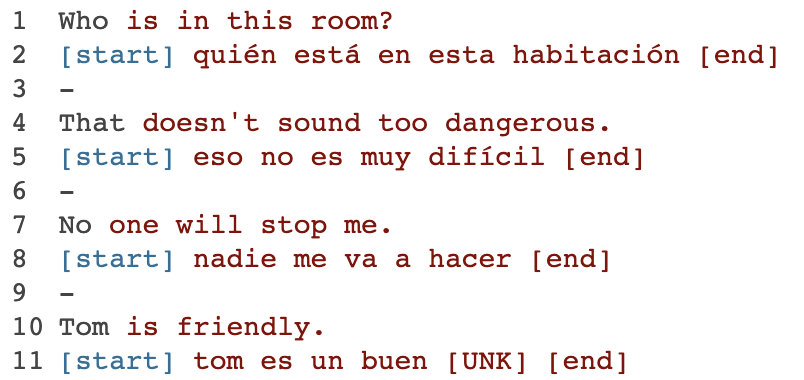

* Formas de **mejorar el modelo:** 
  * Usar una **pila profunda de capas recurrentes** tanto **para el codificador** como para **el decodificador**  
  * Usar un **LSTM** en lugar de un GRU. 
  * etc

Más allá de estos ajustes, el enfoque **RNN para el aprendizaje de secuencia-a-secuencia** tiene **limitaciones fundamentales**:

* **Representación de la secuencia origen debe mantenerse completamente en los vectores de estado del codificador** -> **limitaciones tamaño** y **complejidad** de **oraciones** que puede traducir (como si un humano estuviera traduciendo una oración completamente de memoria)
* **Problemas de las RNN para lidiar con secuencias muy largas**, ya que **tienden a olvidarse progresivamente del pasado**: cuando llega al token número 100 en cualquier secuencia, queda poca información sobre el comienzo de la secuencia (los modelos basados en RNN no pueden aferrarse al contexto a largo plazo, lo que es esencial para traducir documentos extensos).

Estas limitaciones son las que han llevado a la comunidad de aprendizaje automático a **adoptar la arquitectura Transformer** para problemas de secuencia-a-secuencia.

### Aprendizaje Secuencia-a-Secuencia con Transformer

* **Transformer brilla** en el **aprendizaje de secuencia-a-secuencia** 
* La **atención neuronal** permite que los **modelos de Transformer** **procesen con éxito secuencias** que son considerablemente más **largas y complejas** que las que pueden manejar los RNN.
* Un ser humano que traduce inglés a español, **no lee la oración en inglés palabra a palabra, manteniendo su significado en la memoria y luego generando la oración en español palabra a palabra** (puede funcionar para oraciones cortas, pero no para párrafos completos).
* Un traductor humano **alterna entre la oración de origen y la traducción en curso**, **prestando atención a las diferentes palabras de la fuente** **a medida que escribe diferentes partes de su traducción**.
* Eso es exactamente lo que podemos lograr con **atención neuronal** y **Transformers**.  
* **CODIFICADOR TRANSFORMER**
  * El **codificador Transformer**, **utiliza self-attention** para **producir representaciones contextuales de cada token** en una secuencia de entrada. 
  * En un **Transformador de secuencia-a-secuencia**, el **codificador del Transformador** desempeñaría el **papel de leer la secuencia fuente y producir una representación codificada de la misma**. 
  * A diferencia del codificador RNN anterior, el **codificador Transformer mantiene la representación codificada en un formato de secuencia**: es una **secuencia de vectores de embeddings conscientes del contexto (context-aware)**.
* **DECODIFICADOR TRANSFORMER**
  * La **segunda mitad del modelo es el decodificador Transformer**. Al igual que el decodificador RNN, **lee los tokens 0...N en la secuencia objetivo e intenta predecir el token N+1**. 
  * Mientras hace esto, **utiliza la atención neuronal** para identificar qué **tokens en la oración de origen codificada están más estrechamente relacionados con el token de destino que está tratando de predecir actualmente**, tal vez no muy diferente de lo que haría un traductor humano. 
  * Recordemos **el modelo de consulta-clave-valor**: **en un decodificador Transformer, la secuencia de destino sirve como una "consulta" de atención que se utiliza para prestar más atención a las diferentes partes de la secuencia de origen (la secuencia de origen desempeña los roles de claves y valores).**

#### El decoder Transformer

Las **partes internas del decodificador** (**del transformador completo** de secuencia-a-secuencia) **se parece mucho al codificador de Transformer**, excepto que **se inserta un bloque de attention adicional** **entre el bloque de self-attention aplicado a la secuencia de destino y las capas densas del bloque de salida**.

Vamos a implementarlo. Al igual que con el ``TransformerEncoder``, **usaremos una subclase ``Layer``**. Antes de centrarnos en el método ``call()``, donde ocurre la acción, comencemos definiendo el constructor de la clase, que contiene las capas que vamos a necesitar.

**El `TransformerDecoder`**

In [8]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        # Este atributo asegura que la capa propagará 
        # su máscara de entrada a sus salidas; el 
        # enmascaramiento en Keras es explícitamente 
        # opt-in. Si pasa una máscara a una capa que 
        # no implementa compute_mask() y que no expone 
        # este atributo support_masking, es un error.
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

* El **método ``call()``** es una **interpretación sencilla** del diagrama de **conectividad del Transformer** completo salvo por el **relleno causal (causal padding)** (fundamental para entrenar con éxito un transformador de secuencia a secuencia). 
* **A diferencia de un RNN**, que analiza su entrada paso a paso y, por lo tanto, solo tendrá acceso a los pasos 0...N para generar el paso de salida N (que es el token N+1 en la secuencia de destino), el **``TransformerDecoder`` es agnóstico al orden: mira toda la secuencia objetivo a la vez**.

**``TransformerDecoder`` es similar al ``TransformerEncoder``, excepto que presenta un bloque de atención adicional donde las claves y los valores son la secuencia de origen codificada por el ``TransformerEncoder``. Juntos, el codificador y el decodificador forman un transformador de extremo a extremo**

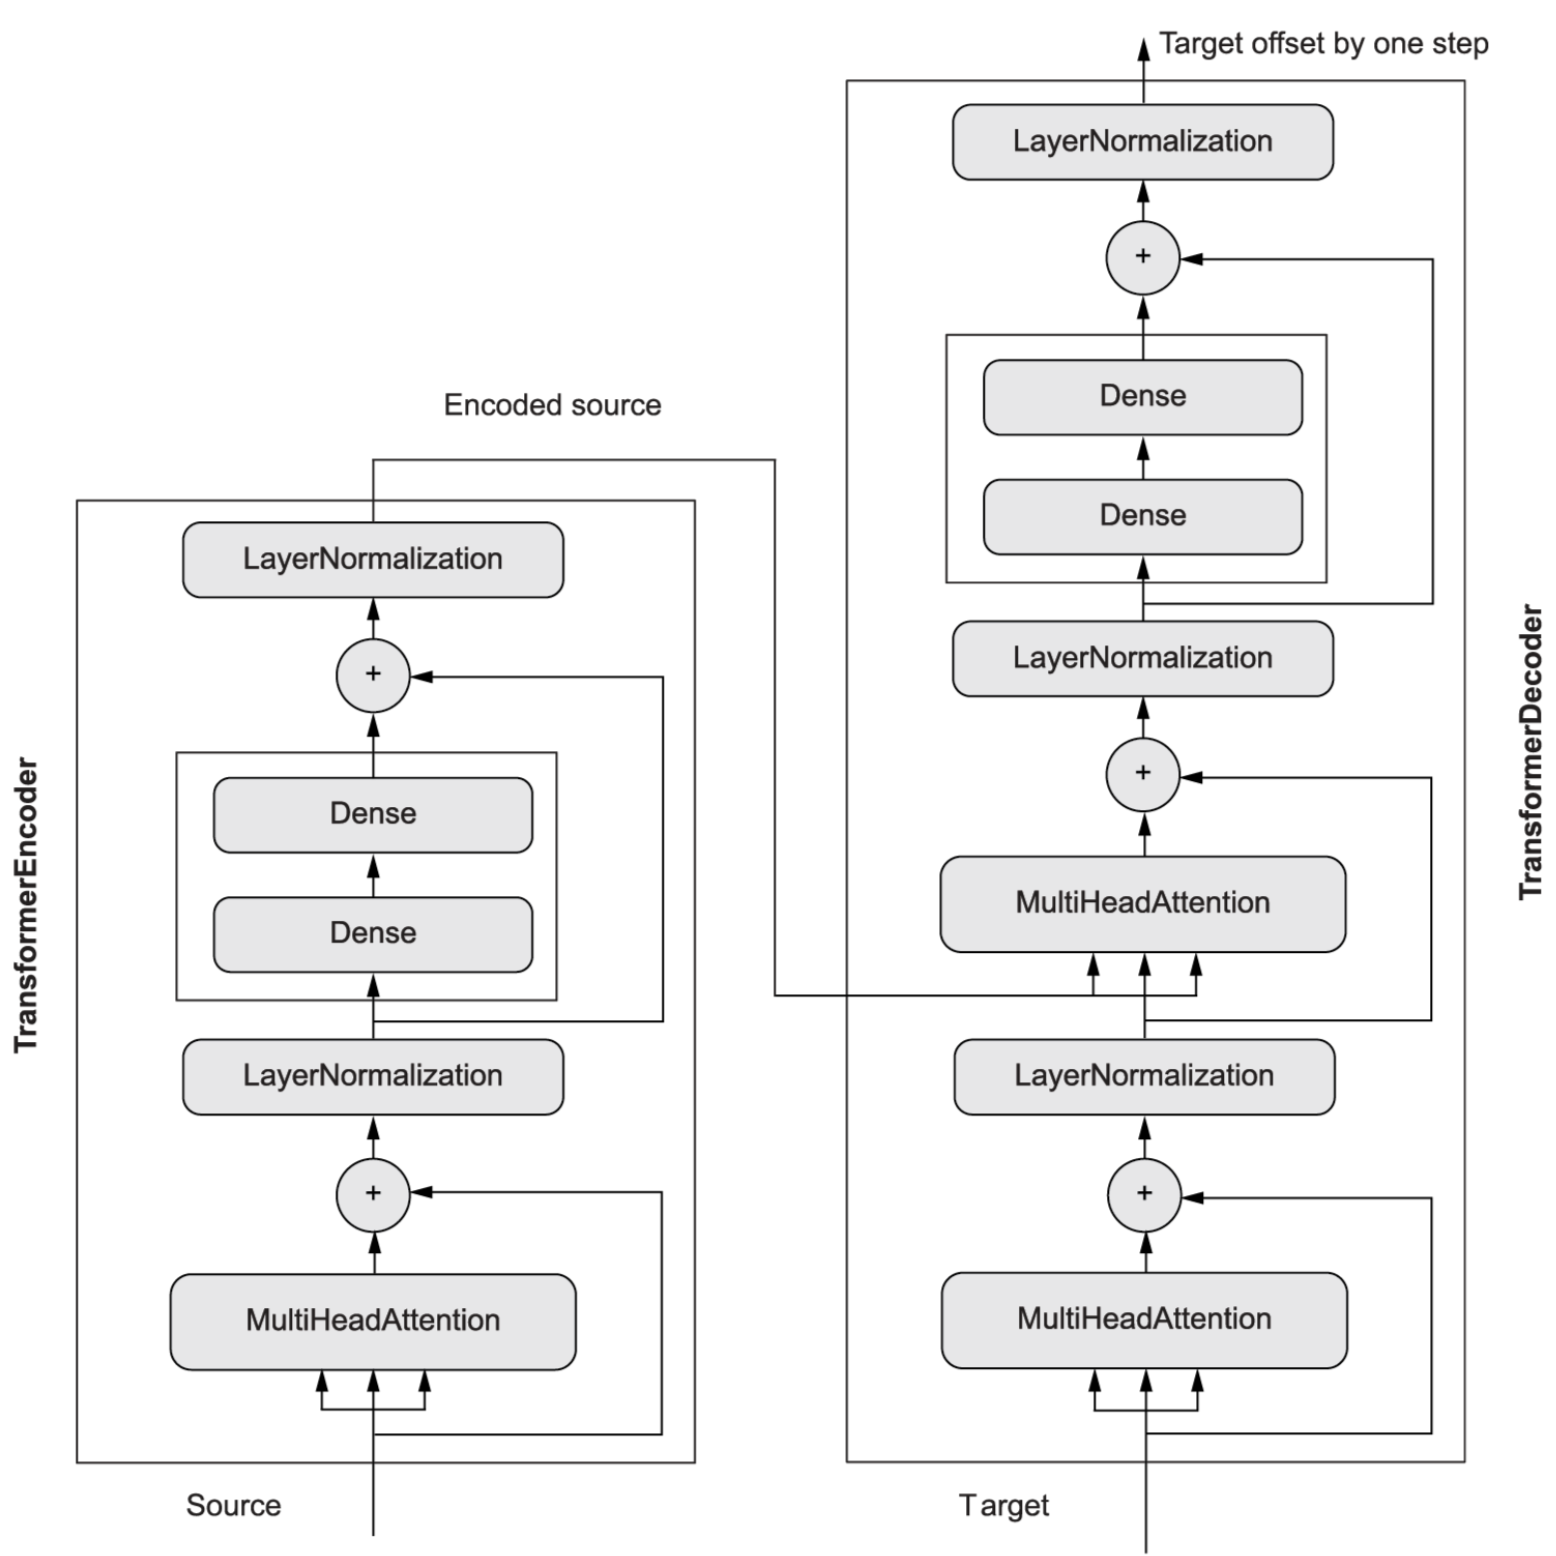

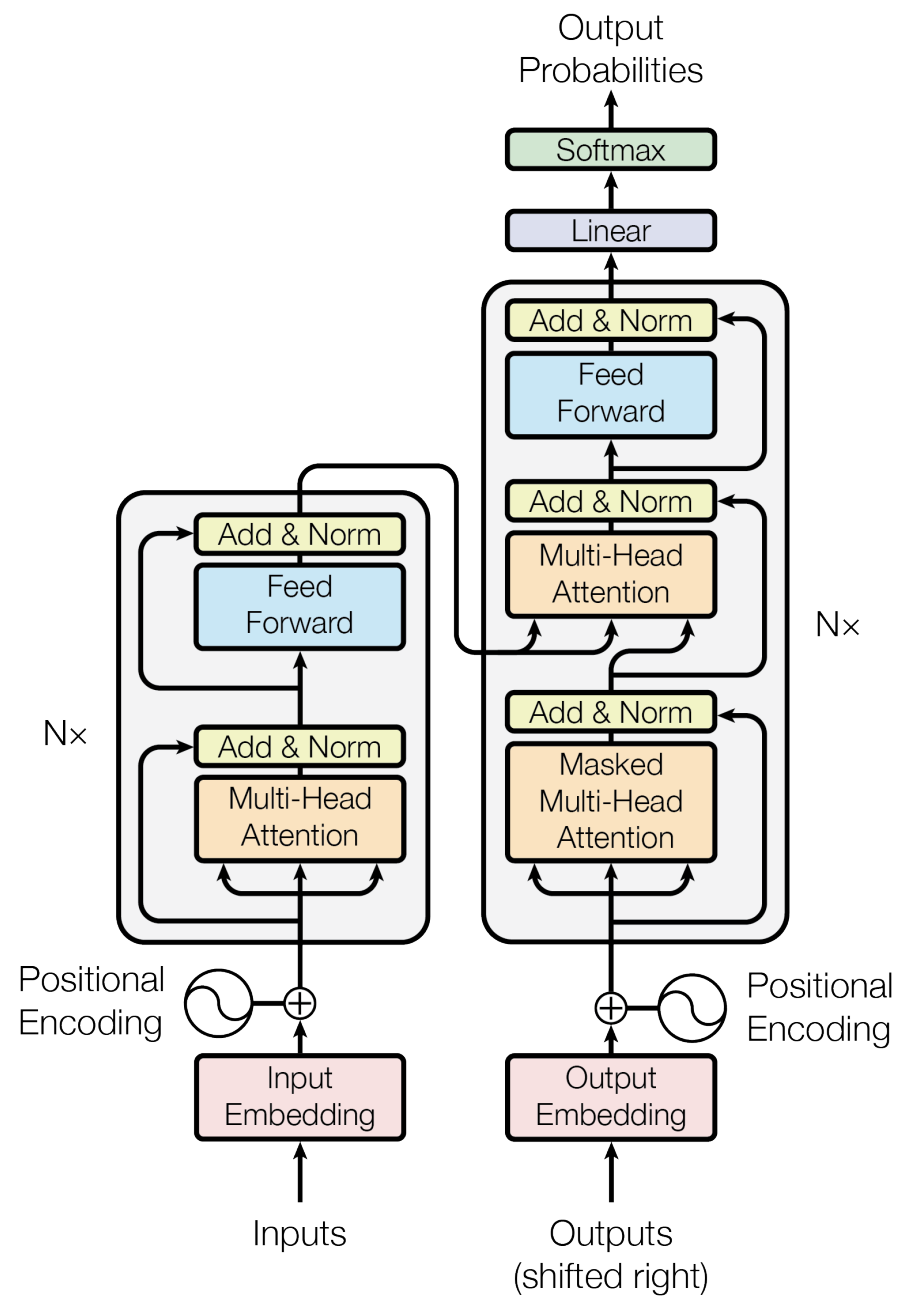

* Procedemos a **enmascarar la mitad superior de la matriz de atención por pares** para **evitar que el modelo preste atención a la información del futuro** (solo se debe usar la información de los tokens 0...N en la secuencia objetivo al generar el token objetivo N+1). 
Para hacer esto, **agregaremos un método ``get_causal_attention_mask(self, inputs)`` a nuestro ``TransformerDecoder``** para **recuperar una máscara de atención que podemos pasar a nuestras capas ``MultiHeadAttention``.**

**Método ``TransformerDecoder`` que genera una máscara causal**

In [9]:
def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        # Genere una matriz de forma (sequence_length, sequence_length) 
        # con 1 en una mitad y 0 en la otra
        mask = tf.cast(i >= j, dtype="int32")
        # Lo replicamos a lo largo del eje del lote para obtener una matriz 
        # de forma  (batch_size, sequence_length, sequence_length)
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

Ahora **podemos escribir el método ``call()`` completo que implementa el paso hacia adelante del decodificador**.

**El paso hacia adelante (forward pass) del ``TransformerDecoder``**

In [10]:
def call(self, inputs, encoder_outputs, mask=None):
        # Recupera la máscara causal
        causal_mask = self.get_causal_attention_mask(inputs)
        # Prepara la máscara de entrada (que describe las 
        # ubicaciones de relleno en la secuencia de destino)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            # Fusiona las dos máscaras juntas
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            # Pasamos la máscara causal a la primera capa de atención, 
            # que realiza la self-attention sobre la secuencia de destino.
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            # Pasamos la máscara combinada a la segunda 
            # capa de atención, que relaciona la secuencia 
            # de origen con la secuencia de destino
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

#### Poniendo todo junto: un Transformer para la traducción automática

* El Transformer de extremo a extremo es el modelo que vamos a entrenar. **Asigna la secuencia de origen y la secuencia de destino** a la **secuencia de destino un paso en el futuro**. 
* Combina de forma sencilla las piezas que hemos creado hasta ahora: **capas ``PositionalEmbedding``**, el **``TransformerEncoder``** y el **``TransformerDecoder``**. 
* Hay que tener en cuenta que **tanto el ``TransformerEncoder`` como el ``TransformerDecoder`` no varían en forma, por lo que podría apilar muchos de ellos para crear un codificador o decodificador más potente**. En nuestro ejemplo, nos ceñiremos a una única instancia de cada uno.

**Capa ``PositionalEmbedding``**

In [11]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**Transformer Extremo-a-Extremo**

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
# Codificamos la oración fuente
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
# Codificamos la oración objetivo y la combinamos con la oración fuente codificada
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
# Predecimos una palabra para cada posición de salida
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

**Entrenando el Transformer Secuencia-a-Secuencia**

Ahora estamos listos para entrenar nuestro modelo: **llegamos al 67% de precisión, bastante por encima del modelo basado en GRU**.

In [16]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
1302/1302 [==============================] - 114s 79ms/step - loss: 3.7996 - accuracy: 0.4397 - val_loss: 2.8988 - val_accuracy: 0.5335
Epoch 2/30
1302/1302 [==============================] - 88s 68ms/step - loss: 2.8517 - accuracy: 0.5497 - val_loss: 2.5298 - val_accuracy: 0.5881
Epoch 3/30
1302/1302 [==============================] - 90s 69ms/step - loss: 2.5550 - accuracy: 0.5931 - val_loss: 2.4388 - val_accuracy: 0.6039
Epoch 4/30
1302/1302 [==============================] - 90s 69ms/step - loss: 2.3932 - accuracy: 0.6193 - val_loss: 2.3548 - val_accuracy: 0.6243
Epoch 5/30
1302/1302 [==============================] - 90s 69ms/step - loss: 2.2875 - accuracy: 0.6377 - val_loss: 2.3279 - val_accuracy: 0.6330
Epoch 6/30
1302/1302 [==============================] - 88s 68ms/step - loss: 2.2203 - accuracy: 0.6506 - val_loss: 2.3008 - val_accuracy: 0.6388
Epoch 7/30
1302/1302 [==============================] - 88s 68ms/step - loss: 2.1609 - accuracy: 0.6622 - val_loss: 2.3220 

Finalmente, **usamos nuestro modelo para traducir oraciones en inglés nunca antes vistas del conjunto de prueba**. La configuración es idéntica a la que usamos para el modelo RNN de secuencia a secuencia.

**Traducir nuevas oraciones con nuestro modelo Transformer**

In [17]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        # Muestra el siguiente token
        sampled_token_index = np.argmax(predictions[0, i, :])
        # Convertimos la siguiente predicción del token en una 
        # cadena y la agregamos a la oración generada
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        # Condición de salida
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
That is the restaurant where we had dinner yesterday.
[start] ese es el restaurante en que había fue a la cena que [UNK] ayer [end]
-
We walked slowly along the road.
[start] nosotros fuimos despacio por el camino [end]
-
I want something sweet to eat.
[start] quiero algo de comer [end]
-
Tom doesn't want to sell his farm.
[start] tom no quiere que le [UNK] en su granja [end]
-
I hope to visit Nara next time.
[start] espero que visitar alemania el próximo el próximo [end]
-
Show me what you've got.
[start] [UNK] lo que tienes [end]
-
It smells as though someone has been smoking in here.
[start] huele a fumar como si alguien [UNK] en aquí [end]
-
Tom asked Mary to take John to the airport.
[start] tom le pidió a mary que le [UNK] al aeropuerto [end]
-
My brother-in-law is a policeman.
[start] mi tienes policía [end]
-
Tom should've danced with Mary.
[start] tom debería haber [UNK] con mary [end]
-
Tom snoozed quietly in front of the TV.
[start] tom se cayó en frente de la televisión [

**Subjetivamente, el Transformador parece funcionar significativamente mejor que el modelo de traducción basado en GRU**. Sigue siendo un modelo de muy simple, pero es un modelo muy simple mejor que el construido con RNNs.

**Algunos resultados de muestra del modelo de traducción de Transformer**

In [ ]:
This is a song I learned when I was a kid.
# Si bien la oración de origen no tenía género, esta traducción 
# asume un hablante masculino. Tenga en cuenta que los modelos de 
# traducción a menudo harán suposiciones injustificadas sobre sus 
# datos de entrada, lo que conduce a un sesgo algorítmico. En el 
# peor de los casos, un modelo puede alucinar con información 
# memorizada que no tiene nada que ver con los datos que está 
# procesando actualmente.
[start] esta es una canción que aprendí cuando era chico [end]
-
She can play the piano.
[start] ella puede tocar piano [end]
-
I'm not who you think I am.
[start] no soy la persona que tú creo que soy [end]
-
It may have rained a little last night.
[start] puede que llueve un poco el pasado [end]

Acabamos de pasar de lo básico a un Transformer completo que puede traducir del inglés al español. Ya sabemos enseñar a las máquinas a dar sentido al lenguaje.

## RESUMEN

* Hay **dos tipos de modelos de PLN**: 
  * Modelos de **bolsa de palabras** que procesan conjuntos de **palabras o N-gramas sin tener en cuenta su orden**. **Se hace con capas ``Dense``**
  * Modelos de **secuencia** que **procesan el orden de las palabras**. Pueden hacerse con **RNN**, un **convnet 1D** o un **transformador**.
* Para **Clasificación de Texto**, la **relación** entre la **cantidad de muestras** en sus datos de entrenamiento y la **cantidad media de palabras por muestra** puede **ayudarnos a determinar si** debemos usar un modelo de **bolsa de palabras** **o** un modelo de **secuencia**.
* Los **words-embeddings** son **espacios vectoriales** donde las **relaciones semánticas entre palabras** se modelan como **relaciones de distancia entre vectores que representan esas palabras**.
* El **aprendizaje de secuencia-a-secuencia** es un **marco de aprendizaje genérico** y poderoso que se puede aplicar para **resolver muchos problemas** de PLN, incluida la **traducción automática**. Consta de un **codificador**, que **procesa** una **secuencia de entrada**, y un **decodificador**, que **intenta predecir tokens futuros** en la secuencia de destino **observando tokens anteriores ya generados** y la **secuencia origen procesada por codificador**.
* La **atención neuronal (neural attention)** es una **forma de crear representaciones de palabras conscientes del contexto**. Es la **base de la arquitectura Transformer**.
* La arquitectura **Transformer**, que **consta de** un **``TransformerEncoder``** y un **``TransformerDecoder``**, produce **excelentes resultados** en **tareas de secuencia-a-secuencia**. **La primera mitad, el ``TransformerEncoder``**, también **se puede usar para la clasificación de texto o cualquier tipo de tarea PLN de entrada única**.